In [1]:
import sys, time, json, re, random
from anytree import Node, RenderTree, PreOrderIter, PostOrderIter, Walker
from anytree.exporter import JsonExporter
from anytree.util import commonancestors
import pandas as pd
from tqdm import tqdm
from itertools import product, combinations
from scipy import spatial
from sentence_transformers import SentenceTransformer

sys.setrecursionlimit(100000)

In [2]:

def group_arguments(tableau):
    argGroup = tableau[0]
    i = 1

    while True:

        if i > len(tableau) - 1:
            # Return if you reach the end of the tableau
            return [argGroup]

        stance = re.search(r"(Con|Pro)(?::)", tableau[i])
        if stance == None:
            argGroup = argGroup + " " + tableau[i]
            i+=1
        else:
            return [argGroup] + group_arguments(tableau[i:]) 


In [3]:
def rawKialo2Json(input_file):
    with open(input_file, 'r') as fi:
        lines = []
        for line in fi:
            if line.startswith("Sources:"):
                break
            lines.append(line.strip())

        lines = [x for x in lines if x]

        # list containing each parsed comment
        result = []

        # we remove the first two lines of the text
        # as we don't need the header
        header = []
        for line in range(0, 4):
            header.append(lines.pop(0))

        subject = header[1]

        lines = group_arguments(lines)

        ##                                            ##
        ##                 REGEDITS                   ##
        ##                                            ##
        # iterate every row in the text file
        counter = 1
        for line in lines:

            # find the tree position the comment is in
            tree =  re.search(r"^(\d{1,}.)+", line)

            # find if the comment is Pro or Con
            stance = re.search(r"(Con|Pro)(?::)", line)

            # find the text of the comment
            content = re.search(r"((Con|Pro)(?::\s))(.*)", line)

            # define the hierarchy of the current comment
            # which is based on the tree structure

            parsed = re.findall(r"(\d{1,}(?=\.))+", tree.group())
            level = len(parsed)-1

            # make a dictionary with the single entry
            # and put it at the end of the list
            result.append({
                "Tree": tree.group(),
                "Level": level,
                "Stance": stance.group(1),
                "ToneInput": content.group(3),
                "node_id":subject.replace(" ","_")+"_"+str(counter)
            })

            counter+=1
        
        to_write = json.dumps(result, sort_keys=True, indent=4, separators=(',', ': '))

    trees = [x["Tree"] for x in result]
    trees = ['1.'] + trees

    resultAsDict = { x["Tree"]: x for x in result }

    id2Node = {}


    for idNode in trees:
        if idNode == '1.':
            id2Node[idNode] = Node(idNode, node_id=-1)
        else:
            parentId = idNode[:idNode[:-1].rfind(".")+1]
            id2Node[idNode] = Node(idNode,
                                    parent=id2Node[parentId],
                                    tree=resultAsDict[idNode]["Tree"], 
                                    level=resultAsDict[idNode]["Level"], 
                                    stance=resultAsDict[idNode]["Stance"], 
                                    toneInput=resultAsDict[idNode]["ToneInput"], 
                                    subject=subject,
                                    node_id=resultAsDict[idNode]["node_id"]
    )

    return id2Node

In [4]:
def pickRandomNodePair(tree):
    nodes = [node.name for node in PreOrderIter(tree['1.'])]
    # Remove root from list of choices
    nodes.pop(0)
    node1_name, node2_name = random.sample(nodes, 2)
    return node1_name, node2_name

def getCommonAncestor(tree, node1_name, node2_name):
    return commonancestors(tree[node1_name], tree[node2_name])

def distanceBetweenPair(tree, node1_name, node2_name):
    walker = Walker()
    path = walker.walk(tree[node1_name], tree[node2_name])
    upwards, _, downwards = path
    return len(upwards) + len(downwards)

def getNeutralPair(tree, threshold):
    """From given tree, pick 2 nodes that are at least `threshold` distance apart and have the root as their only common ancestor (i.e. arguments that aren't directly related)

    Args:
        tree (dict): dictionary of nodes
        threshold (int): minimum distance between nodes

    Raises:
        LookupError: Raised if a pair of nodes that satisfy the conditions cannot be found after 1000 attempts

    Returns:
        tuple(str, str): Pair of node names
    """
    attempt_limit = 1000
    for _ in range(attempt_limit):
        n1, n2 = pickRandomNodePair(tree)
        rootIsOnlyCommonAncestor = len(getCommonAncestor(tree, n1, n2)) == 1
        if not rootIsOnlyCommonAncestor:
            continue
        # First version used a tree walk to compute distance
        # distance = distanceBetweenPair(tree, n1, n2)
        # Use the already set 'level' attribute of the node to compute it instead
        distance = tree[n1].level + tree[n2].level
        if distance < threshold:
            continue
        return n1, n2
    raise LookupError(f"Could not find a pair of nodes that satisfy the conditions after {attempt_limit} attempts")

def getAllNeutralPairsFromSameTree(tree, threshold):
    """Get all pairs of nodes that are at least `threshold` distance apart and have the root as their only common ancestor (i.e. arguments that aren't directly related)

    Args:
        tree (dict): dictionary of nodes representing the tree
        threshold (int): minimum distance between nodes

    Returns:
        list(tuple(str, str)): List of pairs of node names
    """
    root = tree['1.']
    if root.children is None:
        return []

    branches = []
    for child in root.children:
        # generate list of nodes for each 
        branches.append([node.name for node in PostOrderIter(child)])

    nodePairs = []    
    for branchPair in combinations(branches, 2):
        # generate combination of each node in each branch
        nodePairs += list(product(branchPair[0], branchPair[1]))
    
    neutralPairs = []
    for n1, n2 in tqdm(nodePairs, desc="Finding neutral pairs"):
        if n1 == n2:
            continue
        if (n1, n2) in neutralPairs:
            continue
        rootIsOnlyCommonAncestor = len(getCommonAncestor(tree, n1, n2)) == 1
        if not rootIsOnlyCommonAncestor:
            continue
        # First version used a tree walk to compute distance
        # distance = distanceBetweenPair(tree, n1, n2)
        # Use the already set 'level' attribute of the node to compute it instead
        distance = tree[n1].level + tree[n2].level
        if distance < threshold:
            continue
        # Here, could add test via embedding similarity
        neutralPairs.append((n1, n2))
    return neutralPairs

def getAllNeutralPairsFromDiffTrees(t1, t2):
    """Get all pairs of nodes that are from different trees (i.e. arguments that aren't directly related)

    Args:
        t1 (dict): dictionnary of nodes for the first tree
        t2 (dict): dictionnary of nodes for the second tree

    Returns:
        list[tuple[str, str]]: List of pairs of node names
    """
    nodes1 = [node.name for node in PostOrderIter(t1['1.'])]
    nodes2 = [node.name for node in PostOrderIter(t2['1.'])]
    # Remove roots from lists of choices
    nodes1.pop()
    nodes2.pop()
    neutralPairs = list(product(nodes1, nodes2))
    return neutralPairs

def getNNeutralPairsFromSameTrees(tree, threshold, n = 1000):
    """Get `n` pairs of nodes that are at least `threshold` distance apart and have the root as their only common ancestor (i.e. arguments that aren't directly related)

    Args:
        t1 (dict): dictionnary of nodes
        threshold (int): minimum distance between nodes
        n (int, optional): Number of pairs to generate. Defaults to 1000.

    Returns:
        list[tuple[str, str]]: List of pairs of node names
    """
    root = tree['1.']
    if root.children is None:
        return []

    # Only generate pairs of arguments that are in different branches
    # This guarantees that the root is the only common ancestor
    branches = []
    for child in root.children:
        # generate list of nodes for each 
        branches.append([node.name for node in PostOrderIter(child)])

    nodePairs = []
    for branchPair in combinations(branches, 2):
        # generate combination of each node in each branch
        # same as [(x,y) for x in branchPair[0] for y in branchPair[1]]
        nodePairs += list(product(branchPair[0], branchPair[1]))
    
    # Shuffle the list of pairs to avoid bias
    random.shuffle(nodePairs)
    neutralPairs = []
    # Keep generating pairs until we have enough
    while len(neutralPairs) < n and nodePairs:
        n1, n2 = nodePairs.pop()
        # The three tests below are redundant, but kept just in case
        if n1 == n2:
            continue
        if (n1, n2) in neutralPairs:
            continue
        rootIsOnlyCommonAncestor = len(getCommonAncestor(tree, n1, n2)) == 1
        if not rootIsOnlyCommonAncestor:
            continue
        # First version used a tree walk to compute distance
        # distance = distanceBetweenPair(tree, n1, n2)
        # Use the already set 'level' attribute of the node to compute it instead
        distance = tree[n1].level + tree[n2].level
        if distance < threshold:
            continue
        # Here, could add test via embedding similarity
        neutralPairs.append((n1, n2))
    
    return neutralPairs

def getNNeutralPairsFromDiffTrees(t1, t2, n = 1000):
    """Get `n` pairs of nodes that are from different trees (i.e. arguments that aren't directly related)

    Args:
        t1 (dict): dictionnary of nodes for the first tree
        t2 (dict): dictionnary of nodes for the second tree
        n (int, optional): Number of pairs to generate. Defaults to 1000.

    Returns:
        list[tuple[str, str]]: List of pairs of node names
    """
    allNeutralPairs = getAllNeutralPairsFromDiffTrees(t1, t2)
    neutralPairs = random.sample(allNeutralPairs, n)
    return neutralPairs


In [5]:
def argumentTree2argumentPairTree(node, domains):    
    pairs = []
    
    if len(node.children) == 0:
        return pairs
    elif node.children != None:
        for child in node.children:
            if node.name != "1.":
                pair = {
                    "topArgument"       :   node.toneInput,
                    "subArgument"       :   child.toneInput,
                    "subject"           :   child.subject,
                    "subArgumentLevel"  :   child.level,
                    "domain"            :   domains,
                    "sameTree"        :   True
                }
                if child.stance == "Con":
                    pair["relation"] = "attack"
                else:
                    pair["relation"] = "support"
                pairs.append(pair)

            pairs += argumentTree2argumentPairTree(child, domains)
        
    return pairs

In [6]:
def nodePair2NeutralArgPair(node1, node2, domains_n1, domains_n2, same_tree):
    pair = {
            "topArgument"       :   node1.toneInput,
            "subArgument"       :   node2.toneInput,
            "relation"          :   "neutral"
        }

    if same_tree:
        pair["subject"] = node1.subject
        pair["domain"] = domains_n1
        pair["sameTree"] = True
    else:
        pair["subject"] = node1.subject + " & " + node2.subject
        pair["domain"] = domains_n1 + " & " + domains_n2 if domains_n2 else domains_n1
        pair["sameTree"] = False

    return pair

def namePairs2NeutralArgPairs(tree, nodes, domains_n1, tree2=None, domains_n2=None, same_tree=True):
    pairs = []
    for nodeName1, nodeName2 in nodes:
        node1 = tree[nodeName1]
        if same_tree:
            node2 = tree[nodeName2]
        else:
            node2 = tree2[nodeName2]

        pair = nodePair2NeutralArgPair(node1, node2, domains_n1, domains_n2, same_tree)
        pairs.append(pair)

        if same_tree:
            domains_n2 = domains_n1
        reverse_pair = nodePair2NeutralArgPair(node2, node1, domains_n2, domains_n1, same_tree)
        pairs.append(reverse_pair)

    return pairs

In [7]:
import pandas as pd

kialoUrlIds = pd.read_csv("../../rawData/kialo/kialo-url-ids.csv", index_col=0)
pairs = []

prev_d = None
prev_kialoUrlId = None
prev_t = None

for i, x in tqdm(kialoUrlIds.iterrows(), total=kialoUrlIds.shape[0]):
  try:
    d = x.tags
    kialoUrlId = x.kialoUrlId

    # print(x)

    t = rawKialo2Json("../../rawData/kialo/debates/en/"+ kialoUrlId +".txt")
    
    pairs = pairs + argumentTree2argumentPairTree(t['1.'], d)
    
    # neutralPairsSameTree = getAllNeutralPairsFromSameTree(t, 10)
    neutralPairsSameTree = getNNeutralPairsFromSameTrees(t, 10, len(t))
    # print("Len neutral same tree", len(neutralPairsSameTree))

    pairs = pairs + namePairs2NeutralArgPairs(t, neutralPairsSameTree, d)
    
    if prev_d is not None and prev_t is not None:
      # neutralPairsDiffTree = getAllNeutralPairsFromDiffTrees(t, prev_t)
      neutralPairsDiffTree = getNNeutralPairsFromDiffTrees(t, prev_t, max(len(t), len(prev_t)))
      # print("Len neutral diff tree", len(neutralPairsDiffTree))
      
      pairs = pairs + namePairs2NeutralArgPairs(t, neutralPairsDiffTree, d, prev_t, prev_d, same_tree=False)

    prev_d = d
    prev_kialoUrlId = kialoUrlId
    prev_t = t
  except Exception as e:
    continue

100%|██████████| 1000/1000 [01:31<00:00, 10.90it/s]


In [8]:
pairs

[{'topArgument': 'Purity pledges lead to people having a poorer understanding of sexuality.',
  'subArgument': 'Purity pledges lead to people not having a proper understanding of the potential consequences of sex.',
  'subject': 'Are Purity Pledges Harmful?',
  'subArgumentLevel': 2,
  'domain': "['Purity', 'Sex', 'Virginity', 'Feminism', 'Women']",
  'sameTree': True,
  'relation': 'support'},
 {'topArgument': 'Purity pledges lead to people not having a proper understanding of the potential consequences of sex.',
  'subArgument': 'Purity pledges are a facet of abstinence-only sex education [1]. These programs disseminate false information regarding sex.',
  'subject': 'Are Purity Pledges Harmful?',
  'subArgumentLevel': 3,
  'domain': "['Purity', 'Sex', 'Virginity', 'Feminism', 'Women']",
  'sameTree': True,
  'relation': 'support'},
 {'topArgument': 'Purity pledges are a facet of abstinence-only sex education [1]. These programs disseminate false information regarding sex.',
  'subAr

In [9]:
argSrc = [x["subArgument"] for x in pairs]
argTrg = [x["topArgument"] for x in pairs]
topic = [x["domain"] for x in pairs]
relations = [x["relation"] for x in pairs]
sameTree = [x["sameTree"] for x in pairs]

d = pd.DataFrame.from_dict({
  "topic": topic,
  "relation" : relations,
  "argSrc" : argSrc,
  "argTrg" : argTrg,
  "sameTree" : sameTree,
})

d

,topic,relation,argSrc,argTrg,sameTree
0,"['Purity', 'Sex', 'Virginity', 'Feminism', 'Wo...",support,Purity pledges lead to people not having a pro...,Purity pledges lead to people having a poorer ...,True
1,"['Purity', 'Sex', 'Virginity', 'Feminism', 'Wo...",support,Purity pledges are a facet of abstinence-only ...,Purity pledges lead to people not having a pro...,True
2,"['Purity', 'Sex', 'Virginity', 'Feminism', 'Wo...",support,Abstinence programmes are likely to lead to pe...,Purity pledges are a facet of abstinence-only ...,True
3,"['Purity', 'Sex', 'Virginity', 'Feminism', 'Wo...",support,Pledgers often believe contraceptives are unre...,Abstinence programmes are likely to lead to pe...,True
4,"['Purity', 'Sex', 'Virginity', 'Feminism', 'Wo...",support,Abstinence programmes push against [3] increas...,Abstinence programmes are likely to lead to pe...,True
...,...,...,...,...,...
1158077,"['Taxation', 'Economics', 'Welfare', 'Governme...",neutral,Informed consent requires users to have the ne...,Many economists argue that the economy is a ze...,False
1158078,"['AI', 'Humanity', 'Technology'] & ['Taxation'...",neutral,The free-market economy is not a zero sum game...,AI algorithms make unbiased decisions based so...,False
1158079,"['Taxation', 'Economics', 'Welfare', 'Governme...",neutral,AI algorithms make unbiased decisions based so...,The free-market economy is not a zero sum game...,False
1158080,"['AI', 'Humanity', 'Technology'] & ['Taxation'...",neutral,People with disabilities are often more vulner...,Informed consent requires users to have the ne...,False


In [10]:
d.value_counts("relation")

relation
neutral    963806
support     97519
attack      96757
Name: count, dtype: int64

In [11]:
d.value_counts('topic')
d['topic'].isnull().sum()

0

# Clean up 

The arguments still contain some sources, noted by `[124]` for example. We want to remove those.  
Ideally, we should also remove leftover artifacts like mentions of a page number or stuff like `(p. i.)` but that is another hassle for another day. 

In [12]:
# Remove rows with "See" in either argument
pattern = r"-> See (\d\.)*"
d = d[~d['argSrc'].str.contains(pattern)]
d = d[~d['argTrg'].str.contains(pattern)]

# Remove sources from argSrc and argTrg
pattern = r"\s*\[\d+\]"
d['argSrc'] = d['argSrc'].str.replace(pattern, "", regex=True)
d['argTrg'] = d['argTrg'].str.replace(pattern, "", regex=True)

# Remove artifacts like (p. 1), (p. i), (p. ii), (p. 65-66), etc.
pattern = r"\(\s*p\.\s*[\di]+(-\d+)*\s*\)"
d['argSrc'] = d['argSrc'].str.replace(pattern, "", regex=True)
d['argTrg'] = d['argTrg'].str.replace(pattern, "", regex=True)

d

/tmp/ipykernel_4666/2059211311.py:3: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  d = d[~d['argSrc'].str.contains(pattern)]
/tmp/ipykernel_4666/2059211311.py:4: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  d = d[~d['argTrg'].str.contains(pattern)]


,topic,relation,argSrc,argTrg,sameTree
0,"['Purity', 'Sex', 'Virginity', 'Feminism', 'Wo...",support,Purity pledges lead to people not having a pro...,Purity pledges lead to people having a poorer ...,True
1,"['Purity', 'Sex', 'Virginity', 'Feminism', 'Wo...",support,Purity pledges are a facet of abstinence-only ...,Purity pledges lead to people not having a pro...,True
2,"['Purity', 'Sex', 'Virginity', 'Feminism', 'Wo...",support,Abstinence programmes are likely to lead to pe...,Purity pledges are a facet of abstinence-only ...,True
3,"['Purity', 'Sex', 'Virginity', 'Feminism', 'Wo...",support,Pledgers often believe contraceptives are unre...,Abstinence programmes are likely to lead to pe...,True
4,"['Purity', 'Sex', 'Virginity', 'Feminism', 'Wo...",support,Abstinence programmes push against increasing ...,Abstinence programmes are likely to lead to pe...,True
...,...,...,...,...,...
1158077,"['Taxation', 'Economics', 'Welfare', 'Governme...",neutral,Informed consent requires users to have the ne...,Many economists argue that the economy is a ze...,False
1158078,"['AI', 'Humanity', 'Technology'] & ['Taxation'...",neutral,The free-market economy is not a zero sum game...,AI algorithms make unbiased decisions based so...,False
1158079,"['Taxation', 'Economics', 'Welfare', 'Governme...",neutral,AI algorithms make unbiased decisions based so...,The free-market economy is not a zero sum game...,False
1158080,"['AI', 'Humanity', 'Technology'] & ['Taxation'...",neutral,People with disabilities are often more vulner...,Informed consent requires users to have the ne...,False


# Compute Cosine similarity from embeddings

The intuition being that neutral arguments would tend to have orthogonal embeddings, and thus a cosine similarity of 0.

In [13]:
# model = SentenceTransformer("nomic-ai/nomic-embed-text-v1", trust_remote_code=True)
# model = SentenceTransformer("nomic-ai/nomic-embed-text-v2-moe", trust_remote_code=True)

# This model provides the similarity close to 0 for neutrals as opposed to the two above
model = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2", trust_remote_code=True)

def getEmbeddingSimilarity(arg1, arg2):
    return 1 - spatial.distance.cosine(arg1, arg2)

def getEmbeddingsFromArgs(args, model):
    # For nomic models with prompt prefix
    # prompt_prefix = 'clustering: '    
    prompt_prefix = ''    
    sentences = []
    for arg in list(args):
        sentence = prompt_prefix+arg
        sentences.append(sentence)
    embeddings = model.encode(sentences)
    return embeddings

In [14]:
# SUPPORT
embedsSupp = getEmbeddingsFromArgs(["Purity pledges lead to people not having a proper understanding of the potential consequences of sex.", "Purity pledges lead to people having a poorer understanding of sexuality."], model)

# ATTACK
embedsAtt = getEmbeddingsFromArgs(["There is no guarantee that a pledger will be part of an abstinence programme.", "Abstinence programmes are likely to lead to people engaging in unsafe sex."], model)

# NEUTRAL
embedsNeut = getEmbeddingsFromArgs(["In the US, around 2.2 million people are employed in the banking industry in 2023.", "Some coffee producers argue that both Fairtrade and Direct Trade standards are necessary to continue sustainable operations."], model)

print("Support : ", getEmbeddingSimilarity(embedsSupp[0], embedsSupp[1]))
print("Attack", getEmbeddingSimilarity(embedsAtt[0], embedsAtt[1]))
print("Neutral", getEmbeddingSimilarity(embedsNeut[0], embedsNeut[1]))

Support :  0.9118655814964337
Attack 0.43255790666090965
Neutral 0.08010516286836566


In [15]:
tqdm.pandas(desc="Computing similarity for all pairs")

def computeRowCosineSimilarity(row):
    embeddings = getEmbeddingsFromArgs([row["argSrc"], row["argTrg"]], model)
    return getEmbeddingSimilarity(embeddings[0], embeddings[1])

d['similarity'] = d.progress_apply(lambda row: computeRowCosineSimilarity(row), axis=1)

supp = d[d['relation'] == 'support']
att = d[d['relation'] == 'attack']
neut_sameTree = d[(d['relation'] == 'neutral') & (d['sameTree'] == True)]
neut_diffTree = d[(d['relation'] == 'neutral') & (d['sameTree'] == False)]
neut = pd.concat([neut_sameTree, neut_diffTree], ignore_index=True)

d.to_csv("kialoPairsRaw.csv", index=False)

Computing similarity for all pairs: 100%|██████████| 1080548/1080548 [5:53:57<00:00, 50.88it/s]  


In [16]:
# Mean cosine similarity and std for each relation
print("Support : ", supp["similarity"].mean(), '+/-', supp["similarity"].std())
print("Attack : ", att["similarity"].mean(), '+/-', att["similarity"].std())
print("Neutral : ", neut["similarity"].mean(), '+/-', neut["similarity"].std())

Support :  0.5382060315827445 +/- 0.1552481774901807
Attack :  0.5529870581822085 +/- 0.15792942908951313
Neutral :  0.1479163847309437 +/- 0.1411602682253883


### Cosine similarity stats on mixed Neutral relations (same and different tree)

count    894588.000000
mean          0.147916
std           0.141160
min          -0.249697
25%           0.045396
50%           0.122374
75%           0.226943
max           0.861302
Name: similarity, dtype: float64


<Axes: >

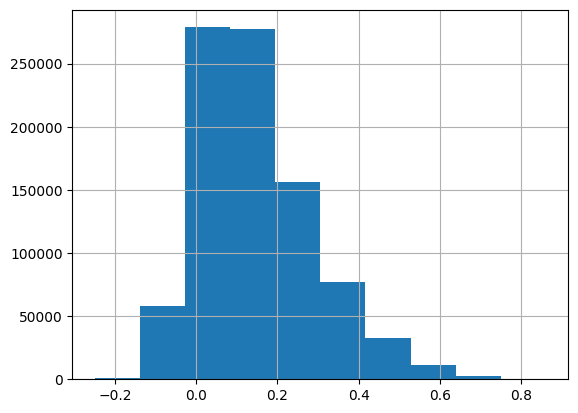

In [17]:
print(neut["similarity"].describe())
neut["similarity"].hist()

### Cosine similarity stats on neutral relations from same Tree

count    330260.000000
mean          0.244230
std           0.148502
min          -0.186417
25%           0.134877
50%           0.231490
75%           0.340350
max           0.861302
Name: similarity, dtype: float64


<Axes: >

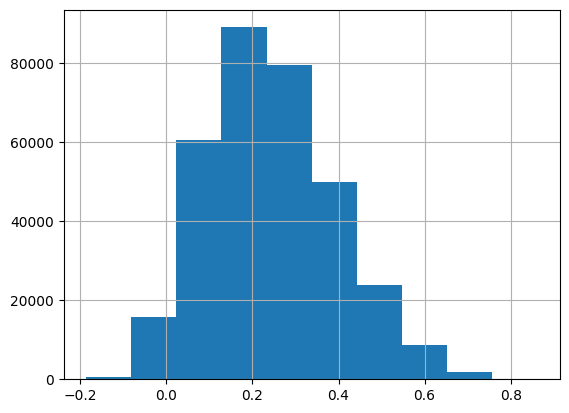

In [18]:
print(neut_sameTree["similarity"].describe())
neut_sameTree["similarity"].hist()

### Cosine similarity stats on neutral relations from different Trees

count    564328.000000
mean          0.091551
std           0.100379
min          -0.249697
25%           0.020887
50%           0.079660
75%           0.149701
max           0.761258
Name: similarity, dtype: float64


<Axes: >

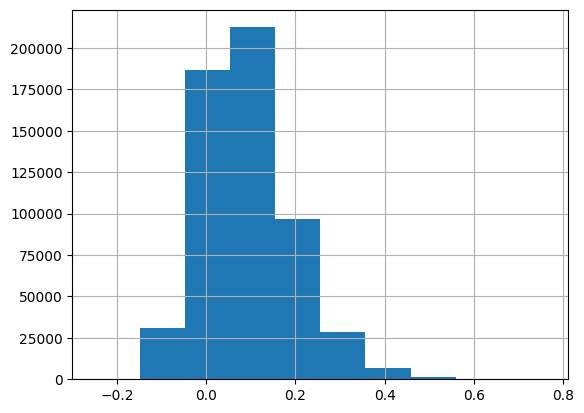

In [19]:
print(neut_diffTree["similarity"].describe())
neut_diffTree["similarity"].hist()

# Post processing

The idea here is to keep only the pairs of neutral arguments that are most neutral, by using the computed Cosine similarity between their embeddings.

In [20]:
import pandas as pd

kp = pd.read_csv("./kialoPairsRaw.csv")

kp 

,topic,relation,argSrc,argTrg,sameTree,similarity
0,"['Purity', 'Sex', 'Virginity', 'Feminism', 'Wo...",support,Purity pledges lead to people not having a pro...,Purity pledges lead to people having a poorer ...,True,0.911866
1,"['Purity', 'Sex', 'Virginity', 'Feminism', 'Wo...",support,Purity pledges are a facet of abstinence-only ...,Purity pledges lead to people not having a pro...,True,0.844139
2,"['Purity', 'Sex', 'Virginity', 'Feminism', 'Wo...",support,Abstinence programmes are likely to lead to pe...,Purity pledges are a facet of abstinence-only ...,True,0.559993
3,"['Purity', 'Sex', 'Virginity', 'Feminism', 'Wo...",support,Pledgers often believe contraceptives are unre...,Abstinence programmes are likely to lead to pe...,True,0.456860
4,"['Purity', 'Sex', 'Virginity', 'Feminism', 'Wo...",support,Abstinence programmes push against increasing ...,Abstinence programmes are likely to lead to pe...,True,0.667410
...,...,...,...,...,...,...
1080543,"['Taxation', 'Economics', 'Welfare', 'Governme...",neutral,Informed consent requires users to have the ne...,Many economists argue that the economy is a ze...,False,-0.020406
1080544,"['AI', 'Humanity', 'Technology'] & ['Taxation'...",neutral,The free-market economy is not a zero sum game...,AI algorithms make unbiased decisions based so...,False,0.180135
1080545,"['Taxation', 'Economics', 'Welfare', 'Governme...",neutral,AI algorithms make unbiased decisions based so...,The free-market economy is not a zero sum game...,False,0.180135
1080546,"['AI', 'Humanity', 'Technology'] & ['Taxation'...",neutral,People with disabilities are often more vulner...,Informed consent requires users to have the ne...,False,0.142073


## Checking the neutrality based on different similarity scores

Let's see if the pairs with negative or close to 0.0 similarity scores are more neutral than others.

### Same Tree

In [21]:
from textwrap import fill

kp_neut_sameTree= kp[(kp['relation'] == 'neutral') & (kp['sameTree'] == True)]
below_zero = kp_neut_sameTree[kp_neut_sameTree['similarity'] < 0]

samples = below_zero.sample(3).values
for row in range(3): 
    print("'topic : ", samples[row][0])
    print("Arg 1 : ", fill(samples[row][2], 140))
    print("Arg 2 : ", fill(samples[row][3], 140))
    print("Similarity ", samples[row][5])
    print("------")

'topic :  ['Society', 'Philosophy', 'Culture', 'Politics']
Arg 1 :  While unemployment rates may not increase, the accumulated effects of people being fired will increase with each subsequent firing and
rehiring.
Arg 2 :  Among traditional liberals, 61% believe that political correctness is a problem.
Similarity  -0.0186105903154962
------
'topic :  ['Politics', 'Ethics', 'USA', 'History', 'Monuments', 'CurrentEvents', 'Statues']
Arg 1 :  Destruction is almost always cheaper than thoughtful creation.
Arg 2 :  Representative republics are republics, governed by law, with democratically elected representatives that craft those laws based on popular
support, personal experience, moral tradition, and precedence from other laws.
Similarity  -0.0181343834847211
------
'topic :  ['Society', 'Philosophy', 'Culture', 'Politics']
Arg 1 :  Occidental is a word Europeans (and other English speakers) use to describe other Europeans. "Oriental" is a term Europeans use to describe
another culture.
Ar

In [22]:
mean_sim = kp_neut_sameTree['similarity'].mean()
std_sim = kp_neut_sameTree['similarity'].std()
print("Mean", mean_sim, "\nStd", std_sim,"\n")
around_mean = kp_neut_sameTree[(kp_neut_sameTree['similarity'] > mean_sim - std_sim) & (kp_neut_sameTree['similarity'] < mean_sim + std_sim)]

samples = around_mean.sample(3).values
for row in range(3): 
    print("'topic : ", samples[row][0])
    print("Arg 1 : ", fill(samples[row][2], 140))
    print("Arg 2 : ", fill(samples[row][3], 140))
    print("Similarity ", samples[row][5])
    print("------")

Mean 0.2442299263765658 
Std 0.14850157135527786 

'topic :  ['LGBTQ', 'Feminism', 'Religion', 'Psychology', 'Sociology', 'Gay']
Arg 1 :  Hegemonic masculinity entails a "mechanism of domination," whereby force and consent operate simultaneously . Therefore, as long as
hegemonic masculinity is still in use, it will not change in any meaningful way.
Arg 2 :  Religious rejection of homosexuality can be explained by authoritarianism and traditional gender beliefs.
Similarity  0.327812135219574
------
'topic :  ['FreeSpeech', 'WhiteSupremacy', 'NoPlatforming', 'Politics', 'USA', 'Law', 'Ethics']
Arg 1 :  Most countries place limits on freedom of speech.
Arg 2 :  This is particularly pertinent for groups targeting younger consumers, who tend to be more affected by the socio-political status of large
companies.
Similarity  0.2108294540149302
------
'topic :  ['Education', 'Equality', 'Freedom', 'Business']
Arg 1 :  Children who study with those from diverse economic backgrounds often reasses

In [23]:
print("Number of rows below zero : ", below_zero.value_counts('relation')['neutral'])
print("Number of rows around the mean : ", around_mean.value_counts('relation')['neutral'])

Number of rows below zero :  9842
Number of rows around the mean :  222478


The pairs with similarity below zero are clearly not related, they almost look like they're from different trees altogether. It is a safe bet to use them for our dataset.

### Different Trees

In [24]:
kp_neut_diffTree= kp[(kp['relation'] == 'neutral') & (kp['sameTree'] == False)]
below_zero = kp_neut_diffTree[kp_neut_diffTree['similarity'] < 0]

samples = below_zero.sample(3).values
for row in range(3): 
    print("'topic : ", samples[row][0])
    print("Arg 1 : ", fill(samples[row][2], 140))
    print("Arg 2 : ", fill(samples[row][3], 140))
    print("Similarity ", samples[row][5])
    print("------")

'topic :  ['Ethics', 'Society', 'Religion', 'Psychology', 'Parenting', 'Children'] & ['Science', 'Humanities', 'Value', 'Morality', 'Ethics']
Arg 1 :  It was artists, in particular the desire for radical change of the futurist Marinetti, that paved the way to fascism in Europe starting  in
the late 19th century.
Arg 2 :  Religion is not the only way that redemption can be provided, examples include services like AA or Suicide Prevention that are not directly
run by religious institutions.
Similarity  -0.0598345920443534
------
'topic :  ['Ethics', 'Philosophy', 'LifeAndDeath', 'Religion', 'God', 'Atheism'] & ['Trump', 'Politics', 'USA', 'Democrats', 'Republicans', 'America']
Arg 1 :  Trump effectively navigated complex trade relations and secured strong trade deals for the US.
Arg 2 :  Verses condemning homosexuality are misinterpreted and do not actually call for discrimination.
Similarity  -0.069450244307518
------
'topic :  ['Society', 'Politics', 'Education', 'Economics', 'USA'] & 

In [25]:
mean_sim = kp_neut_diffTree['similarity'].mean()
std_sim = kp_neut_diffTree['similarity'].std()
print("Mean", mean_sim, "\nStd", std_sim,"\n")
around_mean = kp_neut_diffTree[(kp_neut_diffTree['similarity'] > mean_sim - std_sim) & (kp_neut_diffTree['similarity'] < mean_sim + std_sim)]

samples = around_mean.sample(3).values
for row in range(3): 
    print("'topic : ", samples[row][0])
    print("Arg 1 : ", fill(samples[row][2], 140))
    print("Arg 2 : ", fill(samples[row][3], 140))
    print("Similarity ", samples[row][5])
    print("------")

Mean 0.09155109670007652 
Std 0.10037915204768728 

'topic :  ['Evolution', 'Science', 'Philosophy', 'Faith'] & ['EU', 'Europe', 'Politics', 'Democracy', 'Media']
Arg 1 :  ALDE, the Alliance of Liberals and Democrats for Europe Party is a political party with multiple representatives in the EU parliament, as
well as EU commissioners that identify with ALDE.
Arg 2 :  Claiming that the errors are caused by translation errors does not exonerate it. The book still contains factual errors.
Similarity  0.0101133817535682
------
'topic :  ['Abortion', 'Feminism', 'Gender', 'Democracy'] & ['Sports', 'Feminism', 'Gender']
Arg 1 :  One third of US college athletes are at risk of disordered eating.
Arg 2 :  Many countries do not have conscription.
Similarity  0.063341079354979
------
'topic :  ['Science', 'Animals', 'Ethics', 'Technology'] & ['ChatGPT', 'AI', 'Tech', 'ArtificialIntelligence']
Arg 1 :  ChatGPT can provide support for healthcare professionals in developing nations.
Arg 2 :  Just be

In [26]:
print("Number of rows below zero : ", below_zero.value_counts('relation'))
print("Number of rows around the mean : ", around_mean.value_counts('relation'))

Number of rows below zero :  relation
neutral    98194
Name: count, dtype: int64
Number of rows around the mean :  relation
neutral    396468
Name: count, dtype: int64


### Filter out neutral rows

The objective is to have roughly 100k neutrals with a 50:50 split between sameTree and !sameTree in order to have a balanced dataset to sample from.  
Using the conclusion from the previous exploration, we can determine that it is safe to keep only the most dissimilar pairs (i.e. based on the similarity score in ascending order).

In [27]:
nb_supp = kp.value_counts('relation')['support']
nb_att = kp.value_counts('relation')['attack']

target_nb_neut = (nb_supp + nb_att)//2

nb_supp, nb_att, target_nb_neut, target_nb_neut//2

(93130, 92830, 92980, 46490)

In [28]:
# sort by similarity and keep enough rows reach target_nb_neut
kp_neut_sameTree.sort_values('similarity', inplace=True)
kp_neut_sameTree = kp_neut_sameTree[:target_nb_neut//2]
kp_neut_sameTree

/tmp/ipykernel_4666/2588535892.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  kp_neut_sameTree.sort_values('similarity', inplace=True)


,topic,relation,argSrc,argTrg,sameTree,similarity
104157,"['Philosophy', 'Freedom', 'Humans']",neutral,Frankfurt's first formulation of such cases di...,The human drive to pursue pleasure generally s...,True,-0.186417
104158,"['Philosophy', 'Freedom', 'Humans']",neutral,The human drive to pursue pleasure generally s...,Frankfurt's first formulation of such cases di...,True,-0.186417
122576,"['Ethics', 'Philosophy', 'LifeAndDeath', 'Reli...",neutral,Natural law is a system that has done great ha...,If one sees a connection between two unrelated...,True,-0.182283
122577,"['Ethics', 'Philosophy', 'LifeAndDeath', 'Reli...",neutral,If one sees a connection between two unrelated...,Natural law is a system that has done great ha...,True,-0.182283
901807,"['Games', 'Entertainment', 'VideoGames']",neutral,An art museum is not an artwork.,Character boost allows new players to quickly ...,True,-0.178555
...,...,...,...,...,...,...
85138,"['UnitedKingdom', 'King', 'Charles', 'British'...",neutral,Marriage represents a pledge of loyalty to one...,"The money saved, by reducing the percentage of...",True,0.084749
435422,"['Christianity', 'Bible', 'Atheism', 'God']",neutral,"Jesus dies in Matthew 27:50, before 27:55.","Jude 12 calls wicked people ""clouds without ra...",True,0.084751
435421,"['Christianity', 'Bible', 'Atheism', 'God']",neutral,"Jude 12 calls wicked people ""clouds without ra...","Jesus dies in Matthew 27:50, before 27:55.",True,0.084751
964351,"['Sex', 'Morality', 'Health', 'Entertainment',...",neutral,There are many free counseling and affordable ...,Societal failure to regulate an industry does ...,True,0.084758


In [29]:
# sort by similarity and keep enough rows to reach target_nb_neut
kp_neut_diffTree.sort_values('similarity', inplace=True)
kp_neut_diffTree = kp_neut_diffTree[:target_nb_neut//2]
kp_neut_diffTree

/tmp/ipykernel_4666/2522607491.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  kp_neut_diffTree.sort_values('similarity', inplace=True)


,topic,relation,argSrc,argTrg,sameTree,similarity
978512,"['Politics', 'Trump', 'Ethics', 'USA'] & ['Phi...",neutral,A person may have civil liability in tort law ...,Rasmussen polls trend more conservative than m...,False,-0.249697
978511,"['Philosophy', 'Medicine', 'Morality', 'Ethics...",neutral,Rasmussen polls trend more conservative than m...,A person may have civil liability in tort law ...,False,-0.249697
67846,"['LGBTQ', 'Women', 'Gender', 'Transgender', 'E...",neutral,The EU has not been responsible for the damage...,When gay bars promote interactions between pow...,False,-0.228873
67847,"['EU', 'Aid', 'Earthquake', 'Humanitarian', 'S...",neutral,When gay bars promote interactions between pow...,The EU has not been responsible for the damage...,False,-0.228873
241716,"['Art', 'Culture', 'Ethics', 'Government'] & [...",neutral,A study in Sweden found that only 2.2% of peop...,"Without proper defenses, a nation - including ...",False,-0.211313
...,...,...,...,...,...,...
305842,"['Computers', 'Computing'] & ['Humans', 'Human...",neutral,Australia is a large and sparsely populated co...,"As the hardware, software and algorithms progr...",False,-0.033237
108305,"['LGBTQ', 'Self', 'Defence', 'Gay', 'Lesbian']...",neutral,Words/Ideas possessing a meaning implies that ...,About 35% of women globally and 70% of women n...,False,-0.033237
108306,"['Philosophy', 'Ethics', 'LifeAndDeath'] & ['L...",neutral,About 35% of women globally and 70% of women n...,Words/Ideas possessing a meaning implies that ...,False,-0.033237
175690,"['Christianity', 'Bible', 'Jesus', 'Resurrecti...",neutral,Ability to concentrate is a finite resource an...,"As all are forms of punitive execution, there ...",False,-0.033233


# Concatenate enough neutrals to create a balanced dataset

In [30]:
kp_supp = kp[kp['relation'] == 'support']
kp_att = kp[kp['relation'] == 'attack']

kp_final = pd.concat([kp_supp, kp_att, kp_neut_sameTree, kp_neut_diffTree], ignore_index=True)

kp_final.value_counts('relation')

relation
support    93130
neutral    92980
attack     92830
Name: count, dtype: int64

# Save the final Dataset

In [31]:
kp_final.to_csv("kialoPairs.csv", index=False)